# Análisis del histórico de ventas

En este código realizaremos el análisis estadístico del histórico de ventas de diferentes productos a través de año y medio

In [43]:

import warnings
warnings.filterwarnings("ignore")

## Preprocesamiento

Leemos el archivo y limpiamos

In [10]:
import pandas as pd
import numpy as np
from datetime import timedelta
import openpyxl
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Cargar los datos desde el archivo Excel
data = pd.read_excel('full_datos.xlsx')

# Asegurarse de que la columna Fecha sea del tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Agrupar por semana, sucursal y producto
data['Semana'] = data['Fecha'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_data = data.groupby(['Sucursal', 'Producto', 'Semana']).agg({
    'Precio': 'mean',
    'Cantidad': 'sum',
    'Venta': 'sum',
    'Costo': 'sum'
}).reset_index()

# Calcular Costo_Unitario
weekly_data['Costo_Unitario'] = weekly_data['Costo'] / weekly_data['Cantidad']
weekly_data = weekly_data.fillna(0)  # Llenar valores NaN resultantes de divisiones por 0

# Llenar las semanas faltantes con 0
def fill_missing_weeks(df, start_date, end_date):
    all_weeks = pd.date_range(start=start_date, end=end_date, freq='W-MON')
    df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()
    df.rename(columns={'index': 'Semana'}, inplace=True)
    return df

# Crear características para XGBoost
def create_features(df, label=None):
    df['week'] = df['Semana'].dt.isocalendar().week
    df['month'] = df['Semana'].dt.month
    df['quarter'] = df['Semana'].dt.quarter
    df['year'] = df['Semana'].dt.year
    X = df[['week', 'month', 'quarter', 'year']]
    if label:
        y = df[label]
        return X, y
    return X

# Preparar datos para cada combinación de sucursal-producto
def prepare_data_for_model(df, sucursal, producto):
    df_filtered = df[(df['Sucursal'] == sucursal) & (df['Producto'] == producto)]
    df_filtered = fill_missing_weeks(df_filtered, '2023-01-02', '2024-06-29')
    return df_filtered

# Predecir usando XGBoost
def predict_xgboost(X_train, y_train, X_pred):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(X_train, y_train)
    forecast = model.predict(X_pred)
    return forecast

# Crear gráficos de los datos históricos y las predicciones
def plot_predictions(df, sucursal, producto, pred_fecha, pred_costo_unitario, pred_cantidad):
    plt.figure(figsize=(14, 7))
    
    # Costo Unitario
    plt.subplot(2, 1, 1)
    plt.plot(df['Semana'], df['Costo_Unitario'], label='Histórico Costo Unitario')
    plt.plot(pred_fecha, pred_costo_unitario, label='Predicción Costo Unitario', linestyle='--')
    plt.title(f'Sucursal: {sucursal} - Producto: {producto}')
    plt.xlabel('Fecha')
    plt.ylabel('Costo Unitario')
    plt.legend()
    
    # Cantidad
    plt.subplot(2, 1, 2)
    plt.plot(df['Semana'], df['Cantidad'], label='Histórico Cantidad')
    plt.plot(pred_fecha, pred_cantidad, label='Predicción Cantidad', linestyle='--')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'./Gráficas/predicciones_{sucursal}_{producto}.png')
    plt.close()

# Obtener combinaciones únicas de sucursal y producto
combinaciones = weekly_data[['Sucursal', 'Producto']].drop_duplicates()

predicciones = []

# Aplicar el modelo a cada combinación de sucursal y producto
for _, row in combinaciones.iterrows():
    sucursal = row['Sucursal']
    producto = row['Producto']
    producto = producto.replace('/', '')

    print(f'Sucursal: {sucursal} - Producto: {producto}')
    
    df_model = prepare_data_for_model(weekly_data, sucursal, producto)
    
    # Crear características y etiquetas para el costo unitario
    X_costo_unitario, y_costo_unitario = create_features(df_model, 'Costo_Unitario')
    
    # Crear características y etiquetas para la cantidad
    X_cantidad, y_cantidad = create_features(df_model, 'Cantidad')
    
    # Generar fechas futuras
    pred_weeks = [df_model['Semana'].max() + timedelta(weeks=i) for i in range(1, 13)]
    X_pred = create_features(pd.DataFrame({'Semana': pred_weeks}))
    
    # Predecir costo unitario y cantidad
    pred_costo_unitario = predict_xgboost(X_costo_unitario, y_costo_unitario, X_pred)
    pred_costo_unitario = np.where(pred_costo_unitario < 0, 0, np.round(pred_costo_unitario, 2))
    
    pred_cantidad = predict_xgboost(X_cantidad, y_cantidad, X_pred)
    pred_cantidad = np.where(pred_cantidad < 0, 0, np.round(pred_cantidad, 0))
    
    # Crear gráfica
    plot_predictions(df_model, sucursal, producto, pred_weeks, pred_costo_unitario, pred_cantidad)
    
    predicciones.append(pd.DataFrame({
        'Sucursal': sucursal,
        'Producto': producto,
        'Semana': pred_weeks,
        'Pred_Costo_Unitario': pred_costo_unitario,
        'Pred_Cantidad': pred_cantidad
    }))

# Convertir las predicciones a DataFrame
resultados = pd.concat(predicciones, ignore_index=True)

# Combinar los datos históricos y las predicciones
weekly_data['Pred_Costo_Unitario'] = np.nan
weekly_data['Pred_Cantidad'] = np.nan
combined_data = pd.concat([weekly_data, resultados], ignore_index=True)

# Ordenar los datos por Sucursal, Producto y Semana
combined_data = combined_data.sort_values(by=['Sucursal', 'Producto', 'Semana'])

# Guardar resultados en un archivo Excel
combined_data.to_excel('predicciones.xlsx', index=False)

print("Predicciones guardadas en predicciones.xlsx")


Sucursal: AGROFACIL - Producto: ALLECTUS GR 20 KG
Sucursal: AGROFACIL - Producto: DEMAND DUO 240 ML
Sucursal: AGROFACIL - Producto: FAENA FUERTE 360 LTO
Sucursal: AGROFACIL - Producto: FAENA FUERTE DE 10 LTS
Sucursal: AGROFACIL - Producto: FAENA LTO.
Sucursal: AGROFACIL - Producto: MAXFORCE 30 GR
Sucursal: AGROFACIL - Producto: RYE GRASS PERENE PHD 50 LBS.22.68 KG
Sucursal: AGROFACIL - Producto: STORM CUBETA.(10 KG)
Sucursal: AGROFACIL - Producto: STORM KG.
Sucursal: AGROFACIL - Producto: TERMIDOR (250 ML)
Sucursal: AGROFACIL - Producto: TERMIDOR C.E. LT.
Sucursal: AGROFACIL - Producto: TRAMPA 72MAX DE GOMA (IMP)
Sucursal: ANAHUAC - Producto: ALLECTUS GR 20 KG
Sucursal: ANAHUAC - Producto: DEMAND DUO 240 ML
Sucursal: ANAHUAC - Producto: FAENA FUERTE 360 LTO
Sucursal: ANAHUAC - Producto: FAENA FUERTE DE 10 LTS
Sucursal: ANAHUAC - Producto: FAENA LTO.
Sucursal: ANAHUAC - Producto: HONEY GRAZE SORGHUM X SUDAN 20 KG.
Sucursal: ANAHUAC - Producto: K-OBIOL 10 LTS
Sucursal: ANAHUAC - Producto

C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: ANAHUAC - Producto: UREA (1.5 KG) 46-0-0 (S50kg)


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: BAYER C - Producto: MAXFORCE 30 GR
Sucursal: CANCÚN - Producto: ALLECTUS GR 20 KG
Sucursal: CANCÚN - Producto: DEMAND DUO 240 ML
Sucursal: CANCÚN - Producto: FAENA FUERTE 360 LTO
Sucursal: CANCÚN - Producto: FAENA LTO.
Sucursal: CANCÚN - Producto: MAXFORCE 30 GR
Sucursal: CANCÚN - Producto: OSMOCOTE 14-14-14 22.68KG
Sucursal: CANCÚN - Producto: PHOSTOXIN 333 TABS. 1 KG.
Sucursal: CANCÚN - Producto: PYBUTHRIN 33 20 LTS.
Sucursal: CANCÚN - Producto: STORM CUBETA.(10 KG)
Sucursal: CANCÚN - Producto: STORM KG.
Sucursal: CANCÚN - Producto: SULFATO DE AMONIO 20.5N 50 KGS
Sucursal: CANCÚN - Producto: TERMIDOR (250 ML)
Sucursal: CANCÚN - Producto: TERMIDOR C.E. LT.
Sucursal: CANCÚN - Producto: TRAMPA 72MAX DE GOMA (IMP)
Sucursal: CANCÚN - Producto: TRAMPA 962 GOLD STICK GRANDE
Sucursal: CANCÚN - Producto: TRIPLE 16 (2KG)(16-16-16) S50KG


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: CANCÚN - Producto: UREA (1.5 KG) 46-0-0 (S50kg)


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: CDMX - Producto: ALLECTUS GR 20 KG
Sucursal: CDMX - Producto: DEMAND DUO 240 ML
Sucursal: CDMX - Producto: FAENA FUERTE 360 LTO
Sucursal: CDMX - Producto: FAENA LTO.
Sucursal: CDMX - Producto: K-OBIOL 10 LTS
Sucursal: CDMX - Producto: MAXFORCE 30 GR
Sucursal: CDMX - Producto: PHOSTOXIN 333 TABS. 1 KG.
Sucursal: CDMX - Producto: PLACA DEGESCH
Sucursal: CDMX - Producto: PYBUTHRIN 33 20 LTS.
Sucursal: CDMX - Producto: RYE GRASS PERENE PHD 50 LBS.22.68 KG
Sucursal: CDMX - Producto: STORM CUBETA.(10 KG)
Sucursal: CDMX - Producto: STORM KG.
Sucursal: CDMX - Producto: SULFATO DE AMONIO 20.5N 50 KGS
Sucursal: CDMX - Producto: TERMIDOR (250 ML)
Sucursal: CDMX - Producto: TERMIDOR C.E. LT.
Sucursal: CDMX - Producto: TRAMPA 72MAX DE GOMA (IMP)
Sucursal: CDMX - Producto: TRAMPA 962 GOLD STICK GRANDE
Sucursal: CDMX - Producto: TRIPLE 16 (2KG)(16-16-16) S50KG


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: CDMX - Producto: UREA (1.5 KG) 46-0-0 (S50kg)


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: CHIHUAHUA - Producto: DEMAND DUO 240 ML
Sucursal: CHIHUAHUA - Producto: FAENA FUERTE 360 LTO
Sucursal: CHIHUAHUA - Producto: FAENA LTO.
Sucursal: CHIHUAHUA - Producto: K-OBIOL 10 LTS
Sucursal: CHIHUAHUA - Producto: MAXFORCE 30 GR
Sucursal: CHIHUAHUA - Producto: PHOSTOXIN 333 TABS. 1 KG.
Sucursal: CHIHUAHUA - Producto: PLACA DEGESCH
Sucursal: CHIHUAHUA - Producto: PYBUTHRIN 33 20 LTS.
Sucursal: CHIHUAHUA - Producto: STORM CUBETA.(10 KG)
Sucursal: CHIHUAHUA - Producto: STORM KG.
Sucursal: CHIHUAHUA - Producto: TERMIDOR (250 ML)
Sucursal: CHIHUAHUA - Producto: TERMIDOR C.E. LT.
Sucursal: CHIHUAHUA - Producto: TRAMPA 72MAX DE GOMA (IMP)
Sucursal: CHIHUAHUA - Producto: TRIPLE 16 (2KG)(16-16-16) S50KG


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: CUMBRES - Producto: ALLECTUS GR 20 KG
Sucursal: CUMBRES - Producto: DEMAND DUO 240 ML
Sucursal: CUMBRES - Producto: FAENA FUERTE 360 LTO
Sucursal: CUMBRES - Producto: FAENA FUERTE DE 10 LTS
Sucursal: CUMBRES - Producto: FAENA LTO.
Sucursal: CUMBRES - Producto: HONEY GRAZE SORGHUM X SUDAN 20 KG.
Sucursal: CUMBRES - Producto: MAXFORCE 30 GR
Sucursal: CUMBRES - Producto: OSMOCOTE 14-14-14 22.68KG
Sucursal: CUMBRES - Producto: PHOSTOXIN 333 TABS. 1 KG.
Sucursal: CUMBRES - Producto: RYE GRASS PERENE PHD 50 LBS.22.68 KG
Sucursal: CUMBRES - Producto: STORM CUBETA.(10 KG)
Sucursal: CUMBRES - Producto: STORM KG.
Sucursal: CUMBRES - Producto: SULFATO DE AMONIO 20.5N 50 KGS
Sucursal: CUMBRES - Producto: TERMIDOR (250 ML)
Sucursal: CUMBRES - Producto: TERMIDOR C.E. LT.
Sucursal: CUMBRES - Producto: TRAMPA 72MAX DE GOMA (IMP)
Sucursal: CUMBRES - Producto: TRAMPA 962 GOLD STICK GRANDE
Sucursal: CUMBRES - Producto: TRIPLE 16 (2KG)(16-16-16) S50KG


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: CUMBRES - Producto: UREA (1.5 KG) 46-0-0 (S50kg)


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: GUADALAJARA - Producto: ALLECTUS GR 20 KG
Sucursal: GUADALAJARA - Producto: DEMAND DUO 240 ML
Sucursal: GUADALAJARA - Producto: FAENA LTO.
Sucursal: GUADALAJARA - Producto: MAXFORCE 30 GR
Sucursal: GUADALAJARA - Producto: PHOSTOXIN 333 TABS. 1 KG.
Sucursal: GUADALAJARA - Producto: PLACA DEGESCH
Sucursal: GUADALAJARA - Producto: PYBUTHRIN 33 20 LTS.
Sucursal: GUADALAJARA - Producto: STORM CUBETA.(10 KG)
Sucursal: GUADALAJARA - Producto: STORM KG.
Sucursal: GUADALAJARA - Producto: TERMIDOR (250 ML)
Sucursal: GUADALAJARA - Producto: TERMIDOR C.E. LT.
Sucursal: GUADALAJARA - Producto: TRAMPA 72MAX DE GOMA (IMP)
Sucursal: GUADALAJARA - Producto: TRAMPA 962 GOLD STICK GRANDE
Sucursal: HERMOSILLO - Producto: MAXFORCE 30 GR
Sucursal: HERMOSILLO - Producto: PYBUTHRIN 33 20 LTS.
Sucursal: HERMOSILLO - Producto: STORM CUBETA.(10 KG)
Sucursal: HERMOSILLO - Producto: TERMIDOR (250 ML)
Sucursal: HERMOSILLO - Producto: TERMIDOR C.E. LT.
Sucursal: HERMOSILLO - Producto: TRAMPA 72MAX DE GOMA 

C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: MATRIZ - Producto: UREA (1.5 KG) 46-0-0 (S50kg)


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: MATRIZ - Producto: Vector fog ULV 1-1000 MOD 18-20
Sucursal: MLIBRE - Producto: MAXFORCE 30 GR
Sucursal: MÉRIDA - Producto: DEMAND DUO 240 ML
Sucursal: MÉRIDA - Producto: FAENA LTO.
Sucursal: MÉRIDA - Producto: K-OBIOL 10 LTS
Sucursal: MÉRIDA - Producto: MAXFORCE 30 GR
Sucursal: MÉRIDA - Producto: PHOSTEK 1.5 KG
Sucursal: MÉRIDA - Producto: PHOSTOXIN 333 TABS. 1 KG.
Sucursal: MÉRIDA - Producto: PLACA DEGESCH
Sucursal: MÉRIDA - Producto: PYBUTHRIN 33 20 LTS.
Sucursal: MÉRIDA - Producto: STORM CUBETA.(10 KG)
Sucursal: MÉRIDA - Producto: STORM KG.
Sucursal: MÉRIDA - Producto: TERMIDOR (250 ML)
Sucursal: MÉRIDA - Producto: TERMIDOR C.E. LT.
Sucursal: MÉRIDA - Producto: TRAMPA 72MAX DE GOMA (IMP)
Sucursal: MÉRIDA - Producto: TRAMPA 962 GOLD STICK GRANDE
Sucursal: MÉRIDA - Producto: TRIPLE 16 (2KG)(16-16-16) S50KG


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: MÉRIDA - Producto: UREA (1.5 KG) 46-0-0 (S50kg)


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: SALTILLO - Producto: ALLECTUS GR 20 KG
Sucursal: SALTILLO - Producto: DEMAND DUO 240 ML
Sucursal: SALTILLO - Producto: FAENA FUERTE 360 LTO
Sucursal: SALTILLO - Producto: FAENA FUERTE DE 10 LTS
Sucursal: SALTILLO - Producto: FAENA LTO.
Sucursal: SALTILLO - Producto: HONEY GRAZE SORGHUM X SUDAN 20 KG.
Sucursal: SALTILLO - Producto: MAXFORCE 30 GR
Sucursal: SALTILLO - Producto: OSMOCOTE 14-14-14 22.68KG
Sucursal: SALTILLO - Producto: PHOSTEK 1.5 KG
Sucursal: SALTILLO - Producto: PHOSTOXIN 333 TABS. 1 KG.
Sucursal: SALTILLO - Producto: PLACA DEGESCH
Sucursal: SALTILLO - Producto: PYBUTHRIN 33 20 LTS.
Sucursal: SALTILLO - Producto: RYE GRASS PERENE PHD 50 LBS.22.68 KG
Sucursal: SALTILLO - Producto: STORM CUBETA.(10 KG)
Sucursal: SALTILLO - Producto: STORM KG.
Sucursal: SALTILLO - Producto: SULFATO DE AMONIO 20.5N 50 KGS
Sucursal: SALTILLO - Producto: TERMIDOR (250 ML)
Sucursal: SALTILLO - Producto: TERMIDOR C.E. LT.
Sucursal: SALTILLO - Producto: TRAMPA 72MAX DE GOMA (IMP)
Sucurs

C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: SALTILLO - Producto: UREA (1.5 KG) 46-0-0 (S50kg)


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: VALLE - Producto: ALLECTUS GR 20 KG
Sucursal: VALLE - Producto: DEMAND DUO 240 ML
Sucursal: VALLE - Producto: FAENA FUERTE 360 LTO
Sucursal: VALLE - Producto: FAENA FUERTE DE 10 LTS
Sucursal: VALLE - Producto: FAENA LTO.
Sucursal: VALLE - Producto: MAXFORCE 30 GR
Sucursal: VALLE - Producto: OSMOCOTE 14-14-14 22.68KG
Sucursal: VALLE - Producto: PHOSTOXIN 333 TABS. 1 KG.
Sucursal: VALLE - Producto: PYBUTHRIN 33 20 LTS.
Sucursal: VALLE - Producto: RYE GRASS PERENE PHD 50 LBS.22.68 KG
Sucursal: VALLE - Producto: STORM CUBETA.(10 KG)
Sucursal: VALLE - Producto: STORM KG.
Sucursal: VALLE - Producto: SULFATO DE AMONIO 20.5N 50 KGS
Sucursal: VALLE - Producto: TERMIDOR (250 ML)
Sucursal: VALLE - Producto: TERMIDOR C.E. LT.
Sucursal: VALLE - Producto: TRAMPA 72MAX DE GOMA (IMP)
Sucursal: VALLE - Producto: TRAMPA 962 GOLD STICK GRANDE
Sucursal: VALLE - Producto: TRIPLE 16 (2KG)(16-16-16) S50KG


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: VALLE - Producto: UREA (1.5 KG) 46-0-0 (S50kg)


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Semana').reindex(all_weeks).fillna(0).reset_index()


Sucursal: VILLAHERMO - Producto: DEMAND DUO 240 ML
Sucursal: VILLAHERMO - Producto: K-OBIOL 10 LTS
Sucursal: VILLAHERMO - Producto: PHOSTOXIN 333 TABS. 1 KG.
Sucursal: VILLAHERMO - Producto: PYBUTHRIN 33 20 LTS.
Sucursal: VILLAHERMO - Producto: TERMIDOR C.E. LT.
Sucursal: VILLAHERMO - Producto: TRAMPA 72MAX DE GOMA (IMP)


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\2018014511.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_data = pd.concat([weekly_data, resultados], ignore_index=True)


Predicciones guardadas en predicciones.xlsx


## Modelo de predicción para el costo y la demanda de los próximos 90 días

Usamos el modelo XGBoost para realizar la predicción de la demanda y el costo para los próximos 90 días.

In [11]:
import pandas as pd
import numpy as np
from datetime import timedelta
import openpyxl
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Cargar los datos desde el archivo Excel
data = pd.read_excel('full_datos.xlsx')

# Asegurarse de que la columna Fecha sea del tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Agrupar por día, sucursal y producto
daily_data = data.groupby(['Sucursal', 'Producto', 'Fecha']).agg({
    'Precio': 'mean',
    'Cantidad': 'sum',
    'Venta': 'sum',
    'Costo': 'sum'
}).reset_index()

# Calcular Costo_Unitario
daily_data['Costo_Unitario'] = daily_data['Costo'] / daily_data['Cantidad']
daily_data = daily_data.fillna(0)  # Llenar valores NaN resultantes de divisiones por 0

# Llenar los días faltantes con 0
def fill_missing_days(df, start_date, end_date):
    all_days = pd.date_range(start=start_date, end=end_date)
    df = df.set_index('Fecha').reindex(all_days).fillna(0).reset_index()
    df.rename(columns={'index': 'Fecha'}, inplace=True)
    return df

# Crear características para XGBoost
def create_features(df, label=None):
    df['day'] = df['Fecha'].dt.day
    df['week'] = df['Fecha'].dt.isocalendar().week
    df['month'] = df['Fecha'].dt.month
    df['quarter'] = df['Fecha'].dt.quarter
    df['year'] = df['Fecha'].dt.year
    X = df[['day', 'week', 'month', 'quarter', 'year']]
    if label:
        y = df[label]
        return X, y
    return X

# Preparar datos para cada combinación de sucursal-producto
def prepare_data_for_model(df, sucursal, producto):
    df_filtered = df[(df['Sucursal'] == sucursal) & (df['Producto'] == producto)]
    df_filtered = fill_missing_days(df_filtered, '2023-01-02', '2024-06-29')
    return df_filtered

# Predecir usando XGBoost
def predict_xgboost(X_train, y_train, X_pred):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(X_train, y_train)
    forecast = model.predict(X_pred)
    return forecast

# Crear gráficos de los datos históricos y las predicciones
def plot_predictions(df, sucursal, producto, pred_fecha, pred_costo_unitario, pred_cantidad):
    plt.figure(figsize=(14, 7))
    
    # Costo Unitario
    plt.subplot(2, 1, 1)
    plt.plot(df['Fecha'], df['Costo_Unitario'], label='Histórico Costo Unitario')
    plt.plot(pred_fecha, pred_costo_unitario, label='Predicción Costo Unitario', linestyle='--')
    plt.title(f'Sucursal: {sucursal} - Producto: {producto}')
    plt.xlabel('Fecha')
    plt.ylabel('Costo Unitario')
    plt.legend()
    
    # Cantidad
    plt.subplot(2, 1, 2)
    plt.plot(df['Fecha'], df['Cantidad'], label='Histórico Cantidad')
    plt.plot(pred_fecha, pred_cantidad, label='Predicción Cantidad', linestyle='--')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'.\Gráficas 2\predicciones_{sucursal}_{producto}.png')
    plt.close()

# Obtener combinaciones únicas de sucursal y producto
combinaciones = daily_data[['Sucursal', 'Producto']].drop_duplicates()

predicciones = []

# Aplicar el modelo a cada combinación de sucursal y producto
for _, row in combinaciones.iterrows():
    sucursal = row['Sucursal']
    producto = row['Producto']
    producto = producto.replace('/', '')
    
    df_model = prepare_data_for_model(daily_data, sucursal, producto)
    
    # Crear características y etiquetas para el costo unitario
    X_costo_unitario, y_costo_unitario = create_features(df_model, 'Costo_Unitario')
    
    # Crear características y etiquetas para la cantidad
    X_cantidad, y_cantidad = create_features(df_model, 'Cantidad')
    
    # Generar fechas futuras
    pred_days = [df_model['Fecha'].max() + timedelta(days=i) for i in range(1, 91)]
    X_pred = create_features(pd.DataFrame({'Fecha': pred_days}))
    
    # Predecir costo unitario y cantidad
    pred_costo_unitario = predict_xgboost(X_costo_unitario, y_costo_unitario, X_pred)
    pred_costo_unitario = np.where(pred_costo_unitario < 0, 0, np.round(pred_costo_unitario, 2))
    
    pred_cantidad = predict_xgboost(X_cantidad, y_cantidad, X_pred)
    pred_cantidad = np.where(pred_cantidad < 0, 0, np.round(pred_cantidad, 0))
    
    # Crear gráfica
    plot_predictions(df_model, sucursal, producto, pred_days, pred_costo_unitario, pred_cantidad)
    
    predicciones.append(pd.DataFrame({
        'Sucursal': sucursal,
        'Producto': producto,
        'Fecha': pred_days,
        'Pred_Costo_Unitario': pred_costo_unitario,
        'Pred_Cantidad': pred_cantidad
    }))

# Convertir las predicciones a DataFrame
resultados = pd.concat(predicciones, ignore_index=True)

# Combinar los datos históricos y las predicciones
daily_data['Pred_Costo_Unitario'] = np.nan
daily_data['Pred_Cantidad'] = np.nan
combined_data = pd.concat([daily_data, resultados], ignore_index=True)

# Ordenar los datos por Sucursal, Producto y Fecha
combined_data = combined_data.sort_values(by=['Sucursal', 'Producto', 'Fecha'])

# Guardar resultados en un archivo Excel
combined_data.to_excel('predicciones2.xlsx', index=False)

print("Predicciones guardadas en predicciones2.xlsx")


C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\88443257.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Fecha').reindex(all_days).fillna(0).reset_index()
C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\88443257.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.set_index('Fecha').reindex(all_days).fillna(0).reset_index()
C:\Users\Claudia\AppData\Local\Temp\ipykernel_12060\88443257.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. C

Predicciones guardadas en predicciones2.xlsx


In [13]:
datos =  pd.read_excel("predicciones2.xlsx")
datos

,Sucursal,Producto,Fecha,Precio,Cantidad,Venta,Costo,Costo_Unitario,Pred_Costo_Unitario,Pred_Cantidad
0,AGROFACIL,ALLECTUS GR 20 KG,2023-01-02,1045.2195,0.0,0.0000,0.00,0.00,NaN,NaN
1,AGROFACIL,ALLECTUS GR 20 KG,2023-01-03,1045.2195,0.0,0.0000,0.00,0.00,NaN,NaN
2,AGROFACIL,ALLECTUS GR 20 KG,2023-01-04,1045.2195,0.0,0.0000,0.00,0.00,NaN,NaN
3,AGROFACIL,ALLECTUS GR 20 KG,2023-01-05,1045.2195,1.0,1045.2195,686.32,686.32,NaN,NaN
4,AGROFACIL,ALLECTUS GR 20 KG,2023-01-06,1045.2195,0.0,0.0000,0.00,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
136520,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-23,NaN,NaN,NaN,NaN,NaN,0.0,0.0
136521,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-24,NaN,NaN,NaN,NaN,NaN,0.0,0.0
136522,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-25,NaN,NaN,NaN,NaN,NaN,0.0,0.0
136523,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-26,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [14]:
# Verificar y ajustar los valores en las columnas Pred_Costo_Unitario y Cantidad
def adjust_values(row):
    if row['Pred_Costo_Unitario'] <= 0 or row['Cantidad'] <= 0:
        row['Pred_Costo_Unitario'] = 0
        row['Cantidad'] = 0
    return row

# Aplicar la función de ajuste a cada fila del DataFrame
datos = datos.apply(adjust_values, axis=1)


In [15]:
# Transferir los valores a las columnas Costo_Unitario y Cantidad para fechas >= 2024-06-30
datos.loc[datos['Fecha'] >= pd.to_datetime('2024-06-30'), 'Costo_Unitario'] = datos['Pred_Costo_Unitario']
datos.loc[datos['Fecha'] >= pd.to_datetime('2024-06-30'), 'Cantidad'] = datos['Pred_Cantidad']
datos.loc[datos['Fecha'] >= pd.to_datetime('2024-06-30'), 'Costo'] = datos['Costo_Unitario'] * datos['Cantidad']
datos = datos.drop(columns=['Pred_Costo_Unitario', 'Pred_Cantidad'])
datos

,Sucursal,Producto,Fecha,Precio,Cantidad,Venta,Costo,Costo_Unitario
0,AGROFACIL,ALLECTUS GR 20 KG,2023-01-02,1045.2195,0.0,0.0000,0.00,0.00
1,AGROFACIL,ALLECTUS GR 20 KG,2023-01-03,1045.2195,0.0,0.0000,0.00,0.00
2,AGROFACIL,ALLECTUS GR 20 KG,2023-01-04,1045.2195,0.0,0.0000,0.00,0.00
3,AGROFACIL,ALLECTUS GR 20 KG,2023-01-05,1045.2195,1.0,1045.2195,686.32,686.32
4,AGROFACIL,ALLECTUS GR 20 KG,2023-01-06,1045.2195,0.0,0.0000,0.00,0.00
...,...,...,...,...,...,...,...,...
136520,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-23,NaN,0.0,NaN,0.00,0.00
136521,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-24,NaN,0.0,NaN,0.00,0.00
136522,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-25,NaN,0.0,NaN,0.00,0.00
136523,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-26,NaN,0.0,NaN,0.00,0.00


## Visualización de resultados

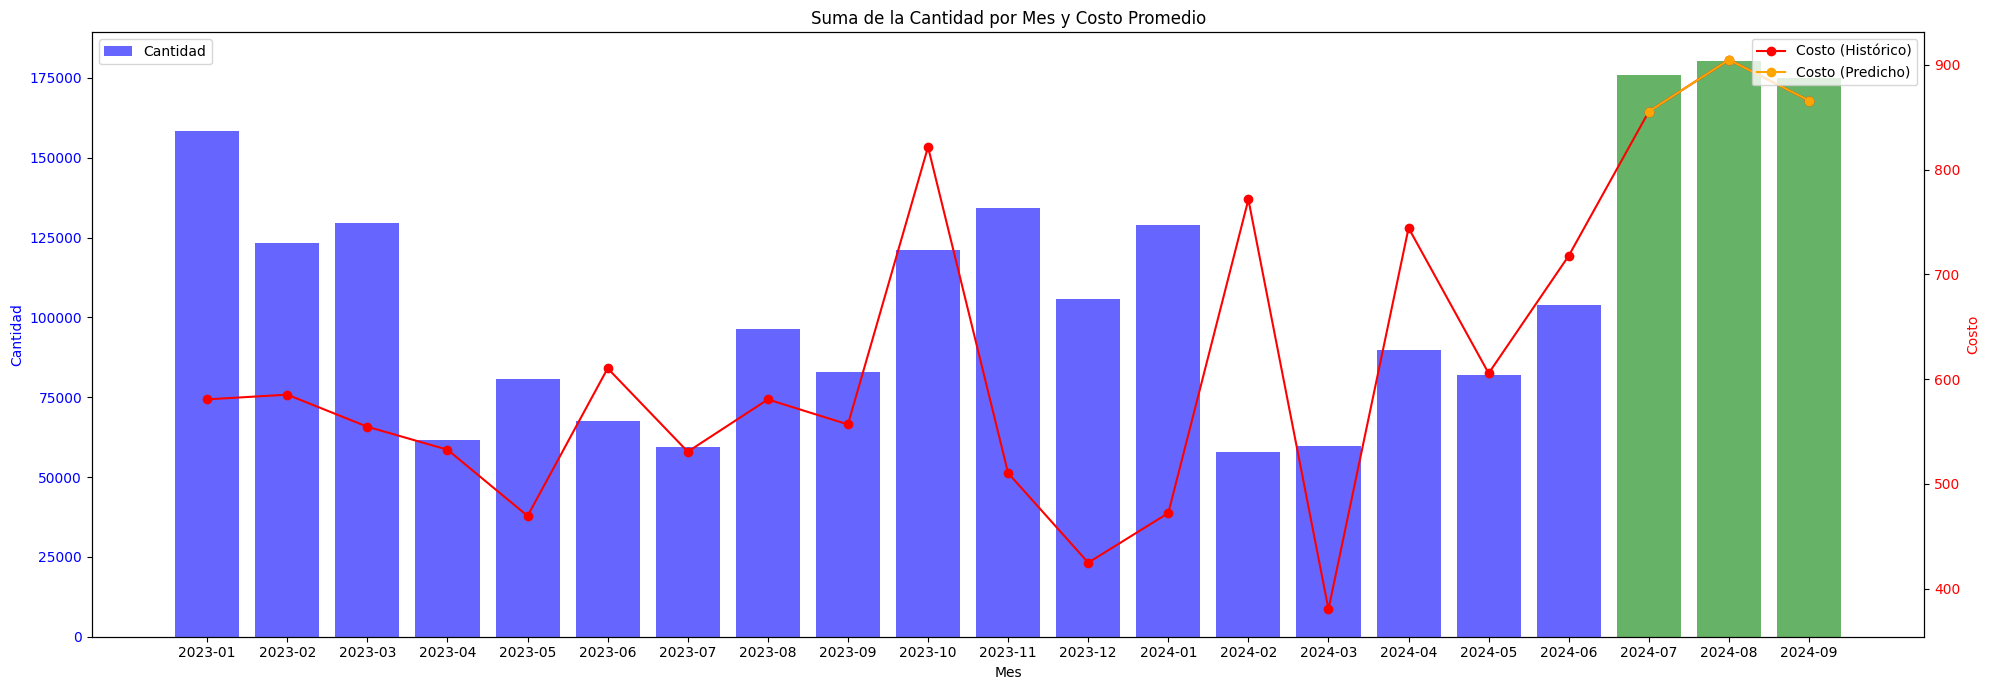

In [18]:
# Agrupar por mes y calcular la suma de la cantidad y el costo promedio
datos['Mes'] = datos['Fecha'].dt.to_period('M')
cantidad_mensual = datos.groupby('Mes')['Cantidad'].sum().reset_index()
costo_mensual = datos.groupby('Mes')['Costo'].mean().reset_index()

# Identificar los meses a partir de julio de 2024 para resaltar
predicted_start = pd.Period('2024-07', freq='M')

# Graficar la cantidad por mes en barras y el costo en líneas
fig, ax1 = plt.subplots(figsize=(20, 7))

# Gráfico de barras para la cantidad
bar_colors = ['b' if mes < predicted_start else 'g' for mes in cantidad_mensual['Mes']]
ax1.bar(cantidad_mensual['Mes'].astype(str), cantidad_mensual['Cantidad'], color=bar_colors, alpha=0.6, label='Cantidad')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Cantidad', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Gráfico de líneas para el costo
ax2 = ax1.twinx()
line_colors = ['r' if mes < predicted_start else 'orange' for mes in costo_mensual['Mes']]
ax2.plot(costo_mensual['Mes'].astype(str), costo_mensual['Costo'], color='r', marker='o', label='Costo (Histórico)')
ax2.plot(costo_mensual[costo_mensual['Mes'] >= predicted_start]['Mes'].astype(str), 
         costo_mensual[costo_mensual['Mes'] >= predicted_start]['Costo'], 
         color='orange', marker='o', label='Costo (Predicho)')
ax2.set_ylabel('Costo', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Título y leyenda
plt.title('Suma de la Cantidad por Mes y Costo Promedio')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar la gráfica
plt.show()

In [20]:
datos.to_excel("datos_costo_cantidad.xlsx", index=False)

In [49]:
datos = pd.read_excel("datos_costo_cantidad.xlsx")
datos = datos.drop(columns=['Mes'])

## Escenario 1: Predecimos la demanda, recorremos costos y precios y calculamos la venta

In [50]:
datos = pd.read_excel("datos_costo_cantidad.xlsx")
datos = datos.drop(columns=['Mes'])

#Eliminar la combinación Sucursa-Producto que no tenga ventas
suma_cantidad = datos.groupby(['Sucursal', 'Producto'])['Cantidad'].sum().reset_index()
suma_cantidad = suma_cantidad[suma_cantidad['Cantidad'] != 0]
datos = datos.merge(suma_cantidad[['Sucursal', 'Producto']], on=['Sucursal', 'Producto'], how='inner')

# Vaciar los valores de la columna Costo en registros >= 2024-06-30
datos.loc[datos['Fecha'] >= '2024-06-30', 'Costo'] = np.nan
datos.loc[datos['Fecha'] >= '2024-06-30', 'Costo_Unitario'] = np.nan
datos.loc[datos['Fecha'] >= '2024-06-30', 'Precio'] = np.nan

# Obtener el último costo diferente de cero para cada combinación de Sucursal-Producto en fecha <= 2024-06-29
costo = datos[datos['Fecha'] <= '2024-06-29']
costo = costo[costo['Costo_Unitario'] != 0]
costo = costo.sort_values(by='Fecha').groupby(['Sucursal', 'Producto']).last().reset_index()
costo = costo.rename(columns={'Costo_Unitario': 'Ultimo_Costo'})

# Obtener el último precio diferente de cero para cada combinación de Sucursal-Producto en fecha <= 2024-06-29
precio = datos[datos['Fecha'] <= '2024-06-29']
precio = precio[precio['Precio'] != 0]
precio = precio.sort_values(by='Fecha').groupby(['Sucursal', 'Producto']).last().reset_index()
precio = precio.rename(columns={'Precio': 'Ultimo_Precio'})

# Unir el DataFrame auxiliar con el DataFrame original
datos = pd.merge(datos, costo[['Sucursal', 'Producto', 'Ultimo_Costo']], on=['Sucursal', 'Producto'], how='left')

# Rellenar los valores vacíos en la columna Costo con los valores de la columna Costo_29_Junio
datos['Costo_Unitario'] = datos['Costo_Unitario'].fillna(datos['Ultimo_Costo'])

datos = datos.drop(columns=['Ultimo_Costo'])

# Unir el DataFrame auxiliar con el DataFrame original
datos = pd.merge(datos, precio[['Sucursal', 'Producto', 'Ultimo_Precio']], on=['Sucursal', 'Producto'], how='left')

# Rellenar los valores vacíos en la columna Costo con los valores de la columna Costo_29_Junio
datos['Precio'] = datos['Precio'].fillna(datos['Ultimo_Precio'])

datos = datos.drop(columns=['Ultimo_Precio'])

datos['Costo'] = datos['Costo'].fillna(datos['Costo_Unitario'] * datos['Cantidad'])
datos['Venta'] = datos['Venta'].fillna(datos['Precio'] * datos['Cantidad'])
datos.loc[datos['Cantidad'] <= 0.0, 'Costo_Unitario'] = 0
datos.loc[datos['Cantidad'] <= 0.0, 'Costo'] = 0
datos.to_excel("datos_escenario_1.xlsx", index=False)
datos

,Sucursal,Producto,Fecha,Precio,Cantidad,Venta,Costo,Costo_Unitario
0,AGROFACIL,ALLECTUS GR 20 KG,2023-01-02,1045.2195,0.0,0.0000,0.00,0.00
1,AGROFACIL,ALLECTUS GR 20 KG,2023-01-03,1045.2195,0.0,0.0000,0.00,0.00
2,AGROFACIL,ALLECTUS GR 20 KG,2023-01-04,1045.2195,0.0,0.0000,0.00,0.00
3,AGROFACIL,ALLECTUS GR 20 KG,2023-01-05,1045.2195,1.0,1045.2195,686.32,686.32
4,AGROFACIL,ALLECTUS GR 20 KG,2023-01-06,1045.2195,0.0,0.0000,0.00,0.00
...,...,...,...,...,...,...,...,...
134990,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-23,6.0000,0.0,0.0000,0.00,0.00
134991,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-24,6.0000,0.0,0.0000,0.00,0.00
134992,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-25,6.0000,0.0,0.0000,0.00,0.00
134993,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-26,6.0000,0.0,0.0000,0.00,0.00


## Escenario 2: Predecimos Demanda y Costos, respetamos último precio y se calcula la venta

In [51]:
datos = pd.read_excel("datos_costo_cantidad.xlsx")
datos = datos.drop(columns=['Mes'])

datos['Costo_Unitario'] = np.where(datos['Cantidad'] == 0,
                                   0,
                                   datos['Costo_Unitario'])

# Vaciar los valores de la columna Costo en registros >= 2024-06-30
datos.loc[datos['Fecha'] >= '2024-06-30', 'Costo'] = np.nan
datos.loc[datos['Fecha'] >= '2024-06-30', 'Precio'] = np.nan

# Obtener el último precio diferente de cero para cada combinación de Sucursal-Producto en fecha <= 2024-06-29
precio = datos[datos['Fecha'] <= '2024-06-29']
precio = precio[precio['Precio'] != 0]
precio = precio.sort_values(by='Fecha').groupby(['Sucursal', 'Producto']).last().reset_index()
precio = precio.rename(columns={'Precio': 'Ultimo_Precio'})

# Unir el DataFrame auxiliar con el DataFrame original
datos = pd.merge(datos, precio[['Sucursal', 'Producto', 'Ultimo_Precio']], on=['Sucursal', 'Producto'], how='left')

# Rellenar los valores vacíos en la columna Costo con los valores de la columna Costo_29_Junio
datos['Precio'] = datos['Precio'].fillna(datos['Ultimo_Precio'])

datos = datos.drop(columns=['Ultimo_Precio'])

datos['Costo'] = datos['Costo'].fillna(datos['Costo_Unitario'] * datos['Cantidad'])
datos['Venta'] = datos['Venta'].fillna(datos['Precio'] * datos['Cantidad'])
datos.loc[datos['Cantidad'] <= 0.0, 'Costo_Unitario'] = 0
datos.loc[datos['Cantidad'] <= 0.0, 'Costo'] = 0
datos.to_excel("datos_escenario_2.xlsx", index=False)
datos

,Sucursal,Producto,Fecha,Precio,Cantidad,Venta,Costo,Costo_Unitario
0,AGROFACIL,ALLECTUS GR 20 KG,2023-01-02,1045.2195,0.0,0.0000,0.00,0.00
1,AGROFACIL,ALLECTUS GR 20 KG,2023-01-03,1045.2195,0.0,0.0000,0.00,0.00
2,AGROFACIL,ALLECTUS GR 20 KG,2023-01-04,1045.2195,0.0,0.0000,0.00,0.00
3,AGROFACIL,ALLECTUS GR 20 KG,2023-01-05,1045.2195,1.0,1045.2195,686.32,686.32
4,AGROFACIL,ALLECTUS GR 20 KG,2023-01-06,1045.2195,0.0,0.0000,0.00,0.00
...,...,...,...,...,...,...,...,...
136520,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-23,6.0000,0.0,0.0000,0.00,0.00
136521,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-24,6.0000,0.0,0.0000,0.00,0.00
136522,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-25,6.0000,0.0,0.0000,0.00,0.00
136523,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-26,6.0000,0.0,0.0000,0.00,0.00


In [ ]:
datos = pd.read_excel("datos_escenario_2.xlsx")
datos = datos.drop(columns=['Mes'])

datos['Costo_Unitario'] = np.nan if (datos['Cantidad'] > 0 and datos['Costo_Unitario'] == 0) else datos['Costo_Unitario']

# Vaciar los valores de la columna Costo en registros >= 2024-06-30
datos.loc[datos['Fecha'] >= '2024-06-30', 'Costo'] = np.nan
datos.loc[datos['Fecha'] >= '2024-06-30', 'Precio'] = np.nan

# Obtener el último precio diferente de cero para cada combinación de Sucursal-Producto en fecha <= 2024-06-29
precio = datos[datos['Fecha'] <= '2024-06-29']
precio = precio[precio['Precio'] != 0]
precio = precio.sort_values(by='Fecha').groupby(['Sucursal', 'Producto']).last().reset_index()
precio = precio.rename(columns={'Precio': 'Ultimo_Precio'})

# Unir el DataFrame auxiliar con el DataFrame original
datos = pd.merge(datos, precio[['Sucursal', 'Producto', 'Ultimo_Precio']], on=['Sucursal', 'Producto'], how='left')

# Rellenar los valores vacíos en la columna Costo con los valores de la columna Costo_29_Junio
datos['Precio'] = datos['Precio'].fillna(datos['Ultimo_Precio'])

datos = datos.drop(columns=['Ultimo_Precio'])

datos['Costo'] = datos['Costo'].fillna(datos['Costo_Unitario'] * datos['Cantidad'])
datos['Venta'] = datos['Venta'].fillna(datos['Precio'] * datos['Cantidad'])
datos.loc[datos['Cantidad'] <= 0.0, 'Costo_Unitario'] = 0
datos.loc[datos['Cantidad'] <= 0.0, 'Costo'] = 0
datos.to_excel("datos_escenario_2.xlsx", index=False)
datos

## Escenario 3: Respetamos último costo, realizamos regresión lineal usando cantidad y costo, estimamos precios y calculamos la venta

In [74]:
import pandas as pd
import numpy as np
datos = pd.read_excel("datos_costo_cantidad.xlsx")
datos = datos.drop(columns=['Mes'])

# Vaciar los valores de la columna Costo en registros >= 2024-06-30
datos.loc[datos['Fecha'] >= '2024-06-30', 'Costo'] = np.nan
datos.loc[datos['Fecha'] >= '2024-06-30', 'Costo_Unitario'] = np.nan
datos.loc[datos['Fecha'] >= '2024-06-30', 'Precio'] = np.nan

# Obtener el último costo diferente de cero para cada combinación de Sucursal-Producto en fecha <= 2024-06-29
costo = datos[datos['Fecha'] <= '2024-06-29']
costo = costo[costo['Costo_Unitario'] != 0]
costo = costo.sort_values(by='Fecha').groupby(['Sucursal', 'Producto']).last().reset_index()
costo = costo.rename(columns={'Costo_Unitario': 'Ultimo_Costo'})

# Unir el DataFrame auxiliar con el DataFrame original
datos = pd.merge(datos, costo[['Sucursal', 'Producto', 'Ultimo_Costo']], on=['Sucursal', 'Producto'], how='left')

# Rellenar los valores vacíos en la columna Costo con los valores de la columna Costo_29_Junio
datos['Costo_Unitario'] = datos['Costo_Unitario'].fillna(datos['Ultimo_Costo'])
datos = datos.drop(columns=['Ultimo_Costo'])
datos['Costo'] = datos['Costo'].fillna(datos['Costo_Unitario'] * datos['Cantidad'])
datos.loc[datos['Cantidad'] <= 0.0, 'Costo_Unitario'] = 0
datos.loc[datos['Cantidad'] <= 0.0, 'Costo'] = 0
datos


,Sucursal,Producto,Fecha,Precio,Cantidad,Venta,Costo,Costo_Unitario
0,AGROFACIL,ALLECTUS GR 20 KG,2023-01-02,1045.2195,0.0,0.0000,0.00,0.00
1,AGROFACIL,ALLECTUS GR 20 KG,2023-01-03,1045.2195,0.0,0.0000,0.00,0.00
2,AGROFACIL,ALLECTUS GR 20 KG,2023-01-04,1045.2195,0.0,0.0000,0.00,0.00
3,AGROFACIL,ALLECTUS GR 20 KG,2023-01-05,1045.2195,1.0,1045.2195,686.32,686.32
4,AGROFACIL,ALLECTUS GR 20 KG,2023-01-06,1045.2195,0.0,0.0000,0.00,0.00
...,...,...,...,...,...,...,...,...
136520,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-23,NaN,0.0,NaN,0.00,0.00
136521,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-24,NaN,0.0,NaN,0.00,0.00
136522,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-25,NaN,0.0,NaN,0.00,0.00
136523,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-26,NaN,0.0,NaN,0.00,0.00


In [75]:
datos_historicos = datos[datos['Fecha'] <= '2024-06-29']
# Agrupar por Sucursal, Producto y Precio, y sumar la Cantidad
agrupado_precio_costo = datos_historicos.groupby(['Sucursal', 'Producto', 'Precio', 'Costo_Unitario']).agg({
    'Cantidad': 'sum'
}).reset_index()
agrupado_precio_costo = agrupado_precio_costo.loc[agrupado_precio_costo['Cantidad'] > 0]

datos_futuros = datos[datos['Fecha'] > '2024-06-29']
# Agrupar por Sucursal, Producto y Precio, y sumar la Cantidad
agrupado_precio_costo_futuro = datos_futuros.groupby(['Sucursal', 'Producto', 'Costo_Unitario']).agg({
    'Cantidad': 'sum'
}).reset_index()
agrupado_precio_costo_futuro = agrupado_precio_costo_futuro.loc[agrupado_precio_costo_futuro['Cantidad'] > 0]

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

agrupado_precio_costo_futuro['Intercepto'] = 0
agrupado_precio_costo_futuro['Coef_Cantidad'] = 0
agrupado_precio_costo_futuro['Coef_Costo'] = 0

#Para cada sucursal y producto hacemos regresión lineal
for (sucursal, producto), grupo in agrupado_precio_costo.groupby(['Sucursal', 'Producto']):
    X = grupo[['Cantidad', 'Costo_Unitario']].values
    y = grupo['Precio'].values

    # Crear un objeto de regresión lineal múltiple
    regression_model = LinearRegression()

    # Ajustar el modelo a los datos
    regression_model.fit(X, y)

    # Obtener los coeficientes de la regresión
    intercept = regression_model.intercept_
    coef_cantidad, coef_costo = regression_model.coef_

    agrupado_precio_costo_futuro.loc[(agrupado_precio_costo_futuro['Sucursal'] == sucursal) &
                                     (agrupado_precio_costo_futuro['Producto'] == producto) & 
                                     (agrupado_precio_costo_futuro['Cantidad'] != 0), 'Intercepto'] = intercept
    agrupado_precio_costo_futuro.loc[(agrupado_precio_costo_futuro['Sucursal'] == sucursal) &
                                     (agrupado_precio_costo_futuro['Producto'] == producto) &
                                     (agrupado_precio_costo_futuro['Cantidad'] != 0), 'Coef_Cantidad'] = coef_cantidad
    agrupado_precio_costo_futuro.loc[(agrupado_precio_costo_futuro['Sucursal'] == sucursal) &
                                     (agrupado_precio_costo_futuro['Producto'] == producto) &
                                     (agrupado_precio_costo_futuro['Cantidad'] != 0), 'Coef_Costo'] = coef_costo

    print(f'Función de regresión de Sucursal {sucursal} - Producto {producto}: precio = {intercept} + {coef_cantidad} * cantidad + {coef_costo} * costo')
agrupado_precio_costo_futuro['Precio'] = 0
agrupado_precio_costo_futuro['Precio'] =  (agrupado_precio_costo_futuro['Intercepto']
                                           + agrupado_precio_costo_futuro['Coef_Cantidad'] * agrupado_precio_costo_futuro['Cantidad']
                                           + agrupado_precio_costo_futuro['Coef_Costo']* agrupado_precio_costo_futuro['Costo_Unitario'])
agrupado_precio_costo_futuro

ultimo_precio = {}
sucursal = ''
producto = ''
precio = ''

for idx, row in datos.iterrows():
    if (row['Fecha'] >= pd.Timestamp('2024-06-29')):
        # Buscar los coeficientes y el intercepto correspondientes en 'agrupado_precio_costo_futuro'
        coef_row = agrupado_precio_costo_futuro[(agrupado_precio_costo_futuro['Sucursal'] == row['Sucursal']) & 
                                                (agrupado_precio_costo_futuro['Producto'] == row['Producto']) & 
                                                (agrupado_precio_costo_futuro['Costo_Unitario'] == row['Costo_Unitario'])]
        
        if not coef_row.empty:
            precio = max(coef_row['Precio'].values[0], precio)
            
            # Actualizar el precio en el DataFrame 'datos'
            datos.at[idx, 'Precio'] = precio
    else:
        precio = row['Precio']

datos['Precio'].fillna(method='ffill', inplace=True)
datos['Venta'] = datos.apply(lambda row: row['Precio'] * row['Cantidad'] if ((row['Fecha'] >= pd.Timestamp('2024-06-29')) &
                                 (row['Cantidad'] > 0)) else row['Venta'], axis=1)
datos['Venta'] = datos['Venta'].fillna(0)
datos.to_excel("datos_escenario_3.xlsx", index=False)
datos

C:\Users\Claudia\AppData\Local\Temp\ipykernel_15720\3678555254.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '56.0779224771386' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  agrupado_precio_costo_futuro.loc[(agrupado_precio_costo_futuro['Sucursal'] == sucursal) &
C:\Users\Claudia\AppData\Local\Temp\ipykernel_15720\3678555254.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8512432536298493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  agrupado_precio_costo_futuro.loc[(agrupado_precio_costo_futuro['Sucursal'] == sucursal) &
C:\Users\Claudia\AppData\Local\Temp\ipykernel_15720\3678555254.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.44228

Función de regresión de Sucursal AGROFACIL - Producto ALLECTUS GR 20 KG: precio = 56.0779224771386 + 0.8512432536298493 * cantidad + 1.442284538540521 * costo
Función de regresión de Sucursal AGROFACIL - Producto DEMAND DUO 240 ML: precio = 490.3446967195282 + 1.740231517114366 * cantidad + -0.6024589787509165 * costo
Función de regresión de Sucursal AGROFACIL - Producto FAENA FUERTE 360 LTO: precio = 413.504 + 0.0 * cantidad + 0.0 * costo
Función de regresión de Sucursal AGROFACIL - Producto FAENA FUERTE DE 10 LTS: precio = 3330.0 + 0.0 * cantidad + 0.0 * costo
Función de regresión de Sucursal AGROFACIL - Producto FAENA LTO.: precio = 348.504 + 0.0 * cantidad + 0.0 * costo
Función de regresión de Sucursal AGROFACIL - Producto MAXFORCE 30 GR: precio = 121815.14338566862 + 1.2317772856605846 * cantidad + -905.5597305814218 * costo
Función de regresión de Sucursal AGROFACIL - Producto RYE GRASS PERENE PHD 50 LBS.22.68 KG: precio = 3120.673907861253 + -0.0013453413635302475 * cantidad + 0

C:\Users\Claudia\AppData\Local\Temp\ipykernel_15720\3678555254.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos['Precio'].fillna(method='ffill', inplace=True)
C:\Users\Claudia\AppData\Local\Temp\ipykernel_15720\3678555254.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datos['Precio'].fillna(method='ffill', inplace=True)


,Sucursal,Producto,Fecha,Precio,Cantidad,Venta,Costo,Costo_Unitario
0,AGROFACIL,ALLECTUS GR 20 KG,2023-01-02,1045.2195,0.0,0.0000,0.00,0.00
1,AGROFACIL,ALLECTUS GR 20 KG,2023-01-03,1045.2195,0.0,0.0000,0.00,0.00
2,AGROFACIL,ALLECTUS GR 20 KG,2023-01-04,1045.2195,0.0,0.0000,0.00,0.00
3,AGROFACIL,ALLECTUS GR 20 KG,2023-01-05,1045.2195,1.0,1045.2195,686.32,686.32
4,AGROFACIL,ALLECTUS GR 20 KG,2023-01-06,1045.2195,0.0,0.0000,0.00,0.00
...,...,...,...,...,...,...,...,...
136520,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-23,6.0000,0.0,0.0000,0.00,0.00
136521,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-24,6.0000,0.0,0.0000,0.00,0.00
136522,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-25,6.0000,0.0,0.0000,0.00,0.00
136523,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-26,6.0000,0.0,0.0000,0.00,0.00


## Escenario 4: Predecimos Costos, calculamos elasticidad, precio óptimo para cada costo, y demanda esperada con el precio óptimo en días donde se estimó que habría venta.

In [13]:
import pandas as pd
import numpy as np
datos = pd.read_excel("datos_costo_cantidad.xlsx")
datos = datos.drop(columns=['Mes'])

# Vaciar los valores de la columna Costo en registros >= 2024-06-30
datos.loc[datos['Fecha'] >= '2024-06-30', 'Precio'] = np.nan

datos.loc[datos['Costo_Unitario'] <= 1, 'Costo_Unitario'] = 0
datos.loc[datos['Cantidad'] <= 0.0, 'Costo_Unitario'] = 0
datos


,Sucursal,Producto,Fecha,Precio,Cantidad,Venta,Costo,Costo_Unitario
0,AGROFACIL,ALLECTUS GR 20 KG,2023-01-02,1045.2195,0.0,0.0000,0.00,0.00
1,AGROFACIL,ALLECTUS GR 20 KG,2023-01-03,1045.2195,0.0,0.0000,0.00,0.00
2,AGROFACIL,ALLECTUS GR 20 KG,2023-01-04,1045.2195,0.0,0.0000,0.00,0.00
3,AGROFACIL,ALLECTUS GR 20 KG,2023-01-05,1045.2195,1.0,1045.2195,686.32,686.32
4,AGROFACIL,ALLECTUS GR 20 KG,2023-01-06,1045.2195,0.0,0.0000,0.00,0.00
...,...,...,...,...,...,...,...,...
136520,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-23,NaN,0.0,NaN,0.00,0.00
136521,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-24,NaN,0.0,NaN,0.00,0.00
136522,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-25,NaN,0.0,NaN,0.00,0.00
136523,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-26,NaN,0.0,NaN,0.00,0.00


In [14]:
datos_historicos = datos[datos['Fecha'] <= '2024-06-29']
# Agrupar por Sucursal, Producto y Precio, y sumar la Cantidad
agrupado_precio_costo = datos_historicos.groupby(['Sucursal', 'Producto', 'Precio', 'Costo_Unitario']).agg({
    'Cantidad': 'sum'
}).reset_index()
agrupado_precio_costo = agrupado_precio_costo.loc[agrupado_precio_costo['Cantidad'] > 0]

datos_futuros = datos[datos['Fecha'] > '2024-06-29']
# Agrupar por Sucursal, Producto y Precio, y sumar la Cantidad
agrupado_precio_costo_futuro = datos_futuros.groupby(['Sucursal', 'Producto', 'Costo_Unitario']).agg({
    'Cantidad': 'sum'
}).reset_index()
agrupado_precio_costo_futuro = agrupado_precio_costo_futuro.loc[agrupado_precio_costo_futuro['Cantidad'] > 0]

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

agrupado_precio_costo_futuro['Intercepto'] = 0
agrupado_precio_costo_futuro['Coef_Cantidad'] = 0
agrupado_precio_costo_futuro['Coef_Costo'] = 0

#Para cada sucursal y producto hacemos regresión lineal
for (sucursal, producto), grupo in agrupado_precio_costo.groupby(['Sucursal', 'Producto']):
    X = grupo[['Cantidad', 'Costo_Unitario']].values
    y = grupo['Precio'].values

    # Crear un objeto de regresión lineal múltiple
    regression_model = LinearRegression()

    # Ajustar el modelo a los datos
    regression_model.fit(X, y)

    # Obtener los coeficientes de la regresión
    intercept = regression_model.intercept_
    coef_cantidad, coef_costo = regression_model.coef_

    agrupado_precio_costo_futuro.loc[(agrupado_precio_costo_futuro['Sucursal'] == sucursal) &
                                     (agrupado_precio_costo_futuro['Producto'] == producto) & 
                                     (agrupado_precio_costo_futuro['Cantidad'] != 0), 'Intercepto'] = intercept
    agrupado_precio_costo_futuro.loc[(agrupado_precio_costo_futuro['Sucursal'] == sucursal) &
                                     (agrupado_precio_costo_futuro['Producto'] == producto) &
                                     (agrupado_precio_costo_futuro['Cantidad'] != 0), 'Coef_Cantidad'] = coef_cantidad
    agrupado_precio_costo_futuro.loc[(agrupado_precio_costo_futuro['Sucursal'] == sucursal) &
                                     (agrupado_precio_costo_futuro['Producto'] == producto) &
                                     (agrupado_precio_costo_futuro['Cantidad'] != 0), 'Coef_Costo'] = coef_costo

    print(f'Función de regresión de Sucursal {sucursal} - Producto {producto}: precio = {intercept} + {coef_cantidad} * cantidad + {coef_costo} * costo')
agrupado_precio_costo_futuro['Precio'] = 0
agrupado_precio_costo_futuro['Precio'] =  (agrupado_precio_costo_futuro['Intercepto']
                                           + agrupado_precio_costo_futuro['Coef_Cantidad'] * agrupado_precio_costo_futuro['Cantidad']
                                           + agrupado_precio_costo_futuro['Coef_Costo']* agrupado_precio_costo_futuro['Costo_Unitario'])
agrupado_precio_costo_futuro

precio = ''
costo = ''

for idx, row in datos.iterrows():
    if (row['Fecha'] >= pd.Timestamp('2024-06-29')):
        # Buscar los coeficientes y el intercepto correspondientes en 'agrupado_precio_costo_futuro'
        coef_row = agrupado_precio_costo_futuro[(agrupado_precio_costo_futuro['Sucursal'] == row['Sucursal']) & 
                                                (agrupado_precio_costo_futuro['Producto'] == row['Producto']) & 
                                                (agrupado_precio_costo_futuro['Costo_Unitario'] == row['Costo_Unitario'])]
        
        if not coef_row.empty:
            if precio > 0:
                if (1 <= coef_row['Precio'].values[0]/precio <= 1.10):
                    precio = coef_row['Precio'].values[0]
            
            # Actualizar el precio en el DataFrame 'datos'
            datos.at[idx, 'Precio'] = precio

        if row['Costo_Unitario'] > 0:
            if (0.9 <= row['Costo_Unitario'] <= 1.10):
                costo = row['Costo_Unitario']
            else:
                datos.at[idx, 'Costo_Unitario'] = costo
        else:
            if row['Cantidad'] > 0:
                datos.at[idx, 'Costo_Unitario'] = costo
    else:
        precio = row['Precio']
        costo = row['Costo_Unitario'] if row['Costo_Unitario'] > 0 else costo

datos['Costo'] = datos['Costo'].fillna(datos['Costo_Unitario'] * datos['Cantidad'])
datos['Costo'] = datos.apply(lambda row: row['Costo_Unitario'] * row['Cantidad'] if ((row['Fecha'] >= pd.Timestamp('2024-06-29')) &
                                 (row['Cantidad'] > 0)) else row['Costo'], axis=1)
datos['Precio'].fillna(method='ffill', inplace=True)
datos['Venta'] = datos.apply(lambda row: row['Precio'] * row['Cantidad'] if ((row['Fecha'] >= pd.Timestamp('2024-06-29')) &
                                 (row['Cantidad'] > 0)) else row['Venta'], axis=1)
datos['Venta'] = datos['Venta'].fillna(0)
datos.to_excel("datos_escenario_4.xlsx", index=False)
datos

C:\Users\Claudia\AppData\Local\Temp\ipykernel_16520\1933417552.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '56.0779224771386' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  agrupado_precio_costo_futuro.loc[(agrupado_precio_costo_futuro['Sucursal'] == sucursal) &
C:\Users\Claudia\AppData\Local\Temp\ipykernel_16520\1933417552.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8512432536298493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  agrupado_precio_costo_futuro.loc[(agrupado_precio_costo_futuro['Sucursal'] == sucursal) &
C:\Users\Claudia\AppData\Local\Temp\ipykernel_16520\1933417552.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.44228

Función de regresión de Sucursal AGROFACIL - Producto ALLECTUS GR 20 KG: precio = 56.0779224771386 + 0.8512432536298493 * cantidad + 1.442284538540521 * costo
Función de regresión de Sucursal AGROFACIL - Producto DEMAND DUO 240 ML: precio = 490.3446967195282 + 1.740231517114366 * cantidad + -0.6024589787509165 * costo
Función de regresión de Sucursal AGROFACIL - Producto FAENA FUERTE 360 LTO: precio = 413.504 + 0.0 * cantidad + 0.0 * costo
Función de regresión de Sucursal AGROFACIL - Producto FAENA FUERTE DE 10 LTS: precio = 3330.0 + 0.0 * cantidad + 0.0 * costo
Función de regresión de Sucursal AGROFACIL - Producto FAENA LTO.: precio = 348.504 + 0.0 * cantidad + 0.0 * costo
Función de regresión de Sucursal AGROFACIL - Producto MAXFORCE 30 GR: precio = 121815.14338566862 + 1.2317772856605846 * cantidad + -905.5597305814218 * costo
Función de regresión de Sucursal AGROFACIL - Producto RYE GRASS PERENE PHD 50 LBS.22.68 KG: precio = 3120.673907861253 + -0.0013453413635302475 * cantidad + 0

C:\Users\Claudia\AppData\Local\Temp\ipykernel_16520\1933417552.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos['Precio'].fillna(method='ffill', inplace=True)
C:\Users\Claudia\AppData\Local\Temp\ipykernel_16520\1933417552.py:76: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datos['Precio'].fillna(method='ffill', inplace=True)


,Sucursal,Producto,Fecha,Precio,Cantidad,Venta,Costo,Costo_Unitario
0,AGROFACIL,ALLECTUS GR 20 KG,2023-01-02,1045.2195,0.0,0.0000,0.00,0.00
1,AGROFACIL,ALLECTUS GR 20 KG,2023-01-03,1045.2195,0.0,0.0000,0.00,0.00
2,AGROFACIL,ALLECTUS GR 20 KG,2023-01-04,1045.2195,0.0,0.0000,0.00,0.00
3,AGROFACIL,ALLECTUS GR 20 KG,2023-01-05,1045.2195,1.0,1045.2195,686.32,686.32
4,AGROFACIL,ALLECTUS GR 20 KG,2023-01-06,1045.2195,0.0,0.0000,0.00,0.00
...,...,...,...,...,...,...,...,...
136520,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-23,6.0000,0.0,0.0000,0.00,0.00
136521,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-24,6.0000,0.0,0.0000,0.00,0.00
136522,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-25,6.0000,0.0,0.0000,0.00,0.00
136523,VILLAHERMO,TRAMPA 72MAX DE GOMA (IMP),2024-09-26,6.0000,0.0,0.0000,0.00,0.00
